# CellChar: A SVM-based characterization method for cellular lines using text processing

## Iván Carrera, Eduardo Tejera, and Inês Dutra
### Departamento de Informática y Ciencias de la Computación, Escuela Politécnica Nacional. Quito, Ecuador.
### Departamento de Ciencia de Computadores, Universidade do Porto, Portugal.
### Grupo de Quimio-Bioinformática, Universidad de Las Américas. Quito, Ecuador.

### Programa de Doutoramento em Ciência de Computadores FCUP.

#### Characterizing Cellular lines
The goal of this work is to characterize cellular lines from processing the related scientific literature

##### Web mining
There are two main source databases for cellular lines: [Cellosaurus](https://web.expasy.org/cellosaurus/)
and [ChEMBL](https://www.ebi.ac.uk/chembl/).
First of all, we have to identify the cellular lines. File contains a list of cellular lines, with their synonyms

Processing Cellosaurus v34

In [1]:
cellosaurus_file = 'data/cellosaurus/cellosaurus.xml'
print('Cellosaurus file:', cellosaurus_file)
with open(cellosaurus_file, 'r') as file_:
    lines = file_.readlines()
    for i in range(107,135):
        print(lines[i].strip('\n'))

import xml.etree.ElementTree as ET
tree = ET.parse(cellosaurus_file)
root = tree.getroot()

cell_dict = dict()
for cell_line in root.find('cell-line-list').findall('cell-line'):
    accession = cell_line.find('accession-list').find('accession')
    name_list = list()
    for name in cell_line.find('name-list').findall('name'):
        name_list.append(name.text)
    species_list = list()
    for species in cell_line.find('species-list').findall('cv-term'):
        species_list.append(species.attrib['accession'])
    reference_list = list()
    try:
        for reference in cell_line.find('reference-list').findall('reference'):
            if 'PubMed' in reference.attrib['resource-internal-ref']:
                reference_list.append(reference.attrib['resource-internal-ref'].replace('PubMed=',''))
    except AttributeError:
        pass
    cell_dict[accession.text] = {'accession': accession.text, 'cell_name': name_list, 'species': species_list,
                      'reference': reference_list}

print('\nCell line examples:')
for cell_ in list(cell_dict.keys())[:2]:
    print(cell_, cell_dict[cell_])

print('\nCellosaurus contains information about', len(cell_dict), 'cellular lines')

Cellosaurus file: data/cellosaurus/cellosaurus.xml
  <accession-list>
    <accession type="primary">CVCL_KA96</accession>
  </accession-list>
  <name-list>
    <name type="identifier">#16-15</name>
  </name-list>
  <comment-list>
    <comment category="Monoclonal antibody target">
      <xref-list>
        <xref database="UniProtKB" category="Sequence databases" accession="Q5T5X7">
          <property-list>
            <property name="gene/protein designation" value="Human BEND3"/>
          </property-list>
          <url><![CDATA[https://www.uniprot.org/uniprot/Q5T5X7]]></url>
        </xref>
      </xref-list>
    </comment>
    <comment category="Monoclonal antibody isotype"> IgM </comment>
  </comment-list>
  <species-list>
    <cv-term terminology="NCBI-Taxonomy" accession="10090">Mus musculus</cv-term>
    <cv-term terminology="NCBI-Taxonomy" accession="10116">Rattus norvegicus</cv-term>
  </species-list>
  <derived-from>
    <cv-term terminology="Cellosaurus" accession="CVCL_40

The goal of this work is to characterize cellular lines from processing the related scientific literature.
In this context, we can understand that verified references are those that appear in cellosaurus as reference.
This will be our _Ground Truth_.

In [2]:
def get_cells_with_min_gtruth_refs(reference_min=0):
    gtruth_idx = list()
    for cell in cell_dict:
        if len(cell_dict[cell]['reference']) >= reference_min:
            gtruth_idx.append(cell)
    return gtruth_idx

gtruth_idx = list()
for i in range(20):
    gtruth_idx = get_cells_with_min_gtruth_refs(i)
    print(len(gtruth_idx),'cell lines with', i, 'or more references')

118785 cell lines with 0 or more references
53209 cell lines with 1 or more references
14526 cell lines with 2 or more references
7383 cell lines with 3 or more references
4357 cell lines with 4 or more references
2987 cell lines with 5 or more references
2236 cell lines with 6 or more references
1753 cell lines with 7 or more references
1401 cell lines with 8 or more references
1168 cell lines with 9 or more references
972 cell lines with 10 or more references
832 cell lines with 11 or more references
710 cell lines with 12 or more references
629 cell lines with 13 or more references
569 cell lines with 14 or more references
510 cell lines with 15 or more references
445 cell lines with 16 or more references
397 cell lines with 17 or more references
354 cell lines with 18 or more references
319 cell lines with 19 or more references


Now, using Entrez API, we can check how many references in PubMed are related to the cellular lines.
First, we transform the list of names for a cellular line into a query for the PubMed search API.

In [3]:
import parse
for cell_ in gtruth_idx[:4]:
    print(cell_, cell_dict[cell_]['cell_name'])
    print(parse.list_toquery(cell_dict[cell_]['cell_name']))

CVCL_7935 ['253J', '253j', '253-J', '253 J', '253J-P', '253J-Parental', '253J P', '253JP']
("253J"[Title/Abstract]) OR ("253j"[Title/Abstract]) OR ("253-J"[Title/Abstract]) OR ("253 J"[Title/Abstract]) OR ("253J-P"[Title/Abstract]) OR ("253J-Parental"[Title/Abstract]) OR ("253J P"[Title/Abstract]) OR ("253JP"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-line[Title/Abstract]))
CVCL_6357 ['451Lu', '451LU', '451-LU', 'WM 451-Lu', 'WM-451Lu', 'WM-451LU', 'WM451Lu', 'WM451', 'WC00059', 'LU451', 'Lu451', 'EST81']
("451Lu"[Title/Abstract]) OR ("451LU"[Title/Abstract]) OR ("451-LU"[Title/Abstract]) OR ("WM 451-Lu"[Title/Abstract]) OR ("WM-451Lu"[Title/Abstract]) OR ("WM-451LU"[Title/Abstract]) OR ("WM451Lu"[Title/Abstract]) OR ("WM451"[Title/Abstract]) OR ("WC00059"[Title/Abstract]) OR ("LU451"[Title/Abstract]) OR ("Lu451"[Title/Abstract]) OR ("EST81"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-l

We can see that there are cell lines with numeric names. These numeric names should be removed from name lists
because they can cause that search queries return false results.

In [4]:
def remove_numeric_names(namelist):
    newlist = list()
    for name in namelist:
        if not str(parse.replace_spchars(name)).replace(' ','').isnumeric():
            newlist.append(name)
    return newlist

list_to_pop = list()
for cell_ in cell_dict:
    newlist = remove_numeric_names(cell_dict[cell_]['cell_name'])
    if len(newlist) == 0:
        list_to_pop.append(cell_)
    cell_dict[cell_]['cell_name'] = newlist

print('There are',len(list_to_pop), 'cell lines with only numeric names.')

for cell_ in list_to_pop:
    try:
        cell_dict.pop(cell_)
    except:
        pass

gtruth_idx = get_cells_with_min_gtruth_refs(1)

print('We are left with', len(cell_dict), 'cell lines.')
print(len(gtruth_idx),'cell lines with', 1, 'or more references')

There are 425 cell lines with only numeric names.
We are left with 118360 cell lines.
52945 cell lines with 1 or more references


We have removed numeric names from cell lines.

Now, using Entrez API, we can check how many references in PubMed are related to the cellular lines.
First, we transform the list of names for a cellular line into a query for the PubMed search API.

In [5]:
for cell_ in gtruth_idx[:4]:
    print(cell_, cell_dict[cell_]['cell_name'])
    print(parse.list_toquery(cell_dict[cell_]['cell_name']))


CVCL_IW91 ['#40a']
("#40a"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-line[Title/Abstract]))
CVCL_VG31 ['0162D']
("0162D"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-line[Title/Abstract]))
CVCL_VG32 ['0165D']
("0165D"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-line[Title/Abstract]))
CVCL_IP58 ['0308-GSC', 'GSC-0308']
("0308-GSC"[Title/Abstract]) OR ("GSC-0308"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-line[Title/Abstract]))


We use that query to retrieve PMIDs by using Entrez API

In [6]:
for cell_ in gtruth_idx[:10]:
    print('_'*80)
    list_ = cell_dict[cell_]['cell_name']
    print(cell_, list_)
    query = parse.list_toquery(list_)
    print(query)
    idlist = parse.search_idlist(query)
    print(cell_, len(idlist), 'references in PubMed')
    print(cell_, len(cell_dict[cell_]['reference']), 'references in Ground Truth')
    comm_ref = list(set(cell_dict[cell_]['reference']).intersection(set(idlist)))
    print(cell_, len(comm_ref), 'references in Ground Truth are in PubMed')

________________________________________________________________________________
CVCL_IW91 ['#40a']
("#40a"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-line[Title/Abstract]))
CVCL_IW91 3 references in PubMed
CVCL_IW91 1 references in Ground Truth
CVCL_IW91 1 references in Ground Truth are in PubMed
________________________________________________________________________________
CVCL_VG31 ['0162D']
("0162D"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-line[Title/Abstract]))
CVCL_VG31 0 references in PubMed
CVCL_VG31 1 references in Ground Truth
CVCL_VG31 0 references in Ground Truth are in PubMed
________________________________________________________________________________
CVCL_VG32 ['0165D']
("0165D"[Title/Abstract]) AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR (cell-line[Title/Abstract]))
CVCL_VG32 0 references in PubMed
CVCL_VG32 1 references in Ground Truth

Now, we can store abstracts to disk.
We will retrieve abstracts in two directories: one for Ground Truth, and other for PubMed references.

In [7]:
for cell_ in gtruth_idx[:10]:
    parse.process_gt_pm(cell_dict[cell_])

# This code should be uncommmented if you wish to retrieve all abstracts
# import multiprocessing
# pool = multiprocessing.Pool(processes=8)
# pool.map(func=parse.process_gt_pm, iterable=cell_dict)

CVCL_IW91 gt file already exists
CVCL_IW91 pubmed file already exists
CVCL_VG31 gt file already exists
CVCL_VG31 0 abstracts from search 0 abstracts to fetch
CVCL_VG32 gt file already exists
CVCL_VG32 0 abstracts from search 0 abstracts to fetch
CVCL_IP58 gt file already exists
CVCL_IP58 0 abstracts from search 0 abstracts to fetch
CVCL_IJ15 gt file already exists
CVCL_IJ15 0 abstracts from search 0 abstracts to fetch
CVCL_WU68 gt file already exists
CVCL_WU68 0 abstracts from search 0 abstracts to fetch
CVCL_V362 gt file already exists
CVCL_V362 0 abstracts from search 0 abstracts to fetch
CVCL_IJ16 gt file already exists
CVCL_IJ16 0 abstracts from search 0 abstracts to fetch
CVCL_J077 gt file already exists
CVCL_J077 0 abstracts from search 0 abstracts to fetch
CVCL_6G61 gt file already exists
CVCL_6G61 0 abstracts from search 0 abstracts to fetch


We now have a full database with retrieved abstracts.
However, for compatibility and standard processing, we should parse json files into two CSV files.

In [8]:
import os
import json
import pandas as pd

gtruth_dir = 'data/cell_json_gt/'
gtruth_df = pd.DataFrame(columns=['title', 'index', 'document', 'cell_id'])
i = 0
for cell_ in gtruth_idx:
    gtruth_file = gtruth_dir + cell_ + '.json'
    if os.path.exists(gtruth_file):
        cell_gtruth_ = json.load(fp=open(gtruth_file, 'r'))
        docs = pd.DataFrame.from_dict(cell_gtruth_['documents'])
        gtruth_df = pd.concat([gtruth_df, docs]).reset_index(drop=True)
        i = i + 1

print(i, 'files in', gtruth_dir)
gtruth_df.to_csv(path_or_buf='data/gt_df.csv', sep=',', header=True, index=True)

pm_dir = 'data/cell_json_pm/'
pm_filelist = os.listdir(pm_dir)

reference_df = pd.DataFrame(columns=['title', 'index', 'document', 'cell_id'])
i = 0
for reference_file in pm_filelist:
    cell_reference_ = json.load(fp=open(pm_dir + reference_file, 'r'))
    docs = pd.DataFrame.from_dict(cell_reference_['documents'])
    reference_df = pd.concat([reference_df, docs]).reset_index(drop=True)
    i = i + 1

print(i, 'files in', pm_dir)
reference_df.to_csv(path_or_buf='data/pm_df.csv', sep=',', header=True, index=True)

52945 files in data/cell_json_gt/
4087 files in data/cell_json_pm/


If you don't want to have to retrieve all that information, you can read directly from the CSV file.

In [1]:
import pandas as pd

gtruth_file = 'data/gt_df.csv'
reference_file = 'data/pm_df.csv'

gtruth_df = pd.read_csv(gtruth_file, sep=',', error_bad_lines=False, encoding="latin-1",
                         index_col=0, header=0)
reference_df = pd.read_csv(reference_file, sep=',', error_bad_lines=False, encoding="latin-1",
                         index_col=0, header=0)

print('GTruth Document table has information on', gtruth_df.shape[0], 'documents of',
      gtruth_df['cell_id'].unique().shape[0], 'cell lines')
print('Reference Document table has information on', reference_df.shape[0], 'documents of',
      reference_df['cell_id'].unique().shape[0], 'cell lines')

GTruth Document table has information on 97433 documents of 52945 cell lines
Reference Document table has information on 161027 documents of 4087 cell lines


Now that we have loaded the corpus, we can process it.
First, we remove all references and ground truth that is not common.

In [2]:
gt_count = gtruth_df.groupby(by=['cell_id'])['cell_id'].count()
gtruth_df = gtruth_df[gtruth_df.cell_id.isin(gt_count[gt_count > 2].index)]
pm_count = reference_df.groupby(by=['cell_id'])['cell_id'].count()
reference_df = reference_df[reference_df.cell_id.isin(pm_count[pm_count > 2].index)]

gtruth_cells = gtruth_df['cell_id'].unique()
reference_cells = reference_df['cell_id'].unique()
cell_intersection = set(gtruth_cells).intersection(set(reference_cells))

print('Datasets have', len(cell_intersection), 'common cell lines')

gtruth_df = gtruth_df[gtruth_df.cell_id.isin(cell_intersection)].reset_index(drop=True)
reference_df = reference_df[reference_df.cell_id.isin(cell_intersection)].reset_index(drop=True)

print('GTruth Document table has information on', gtruth_df.shape[0], 'documents of',
      gtruth_df['cell_id'].unique().shape[0], 'cell lines')
print('Reference Document table has information on', reference_df.shape[0], 'documents of',
      reference_df['cell_id'].unique().shape[0], 'cell lines')

reference_df = pd.concat([reference_df, gtruth_df]).reset_index(drop=True)
pm_count = reference_df.groupby(by=['cell_id'])['cell_id'].count()
print('Every cell line has at least', min(pm_count), 'documents')


Datasets have 952 common cell lines
GTruth Document table has information on 7482 documents of 952 cell lines
Reference Document table has information on 74587 documents of 952 cell lines
Every cell line has at least 6 documents


We define _crossval_ method for processing the dataframe.
_crossval_ method filters cell lines with _min_references_ documents.

In [11]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from nltk.stem.porter import PorterStemmer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer

def crossval(df, min_references, stemmed=False):
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    df = df[df.cell_id.isin(pm_count[pm_count >= min_references].index)]
    df = df[df.cell_id.isin(pm_count[pm_count < 500].index)]
    print(df.shape[0], 'abstracts in corpus')
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    print('Every cell line has at least', min(pm_count), 'documents')

    if stemmed:
        stemmer = PorterStemmer()
        stemmed_corpus = list()
        for doc in df['document']:
            doc = doc.replace('.', '').replace(',', '').replace(';', '').replace(':', '')
            stemmed_corpus.append(' '.join([stemmer.stem(x) for x in doc.split()]))
        corpus = stemmed_corpus
    else:
        corpus = df['document']

    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=1.0, min_df=2, strip_accents='ascii', stop_words='english',
                                 token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
    dtm = vectorizer.fit_transform(corpus)
    print('DTM shape:', dtm.shape)
    wordfreq = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    print('Top 20 words')
    print(sorted(wordfreq.items(), key=lambda x: x[1])[:20])
    reference_vocab = vectorizer.get_feature_names()
    print(len(reference_vocab), 'words')

    X, y = dtm, df['cell_id']
    scoring = ['precision_micro', 'recall_micro']
    param_grid = {'C': [1, 10], 'kernel': ('linear', 'rbf')}
    svc = SVC(decision_function_shape='ovr')
    clf = GridSearchCV(estimator=svc, param_grid=param_grid, return_train_score=True, cv=10, n_jobs=-1,
                       scoring=scoring, refit='recall_micro', verbose=1)
    clf = clf.fit(X=X, y=y, groups=df['cell_id'])
    return {'clf': clf, 'estimator': clf.best_estimator_, 'pm_count': pm_count}


results_min_ref = dict()
for min_ref in [10, 50, 100]:
    print('_'*80)
    print(min_ref, 'minimum references')
    results_min_ref[min_ref] = crossval(df=reference_df, min_references=min_ref, stemmed=False)

________________________________________________________________________________
10 minimum references
52780 abstracts in corpus
Every cell line has at least 10 documents
DTM shape: (52780, 58780)
Top 20 words
[('cell', 1.0184522955857487), ('line', 1.075924084408676), ('cells', 1.2501674871604203), ('human', 1.6265811033751543), ('expression', 1.77653949828469), ('results', 1.799158394477844), ('lines', 1.9221527865028858), ('study', 2.0014453825174963), ('protein', 2.0943395858318516), ('using', 2.1268389231836755), ('cancer', 2.1414446009644768), ('induced', 2.231783768046781), ('activity', 2.310096371482535), ('showed', 2.3226751536893953), ('tumor', 2.3468594329799215), ('gene', 2.3486824545953935), ('vitro', 2.3728387538345777), ('used', 2.373063094833836), ('effect', 2.3804193808222998), ('growth', 2.3863890966656855)]
58780 words
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  40 | elapsed: 191.2min remaining: 397.0min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 237.3min finished


________________________________________________________________________________
50 minimum references
41842 abstracts in corpus
Every cell line has at least 50 documents
DTM shape: (41842, 52270)
Top 20 words
[('cell', 1.0143946255943683), ('line', 1.048626470376825), ('cells', 1.231947095961191), ('human', 1.6426548186440084), ('expression', 1.7666431615270874), ('results', 1.7792746904543022), ('study', 1.965720394985106), ('lines', 2.006529311541077), ('protein', 2.068642649655791), ('using', 2.1190135225484767), ('cancer', 2.1840887992555746), ('induced', 2.188863946299316), ('activity', 2.270411761806735), ('showed', 2.2989962389253042), ('effect', 2.3273398358945325), ('vitro', 2.356603079799), ('used', 2.3566958829172515), ('gene', 2.3712796694853546), ('tumor', 2.375999330879853), ('treatment', 2.395103933330922)]
52270 words
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  40 | elapsed: 73.5min remaining: 152.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 92.6min finished


________________________________________________________________________________
100 minimum references
33511 abstracts in corpus
Every cell line has at least 100 documents
DTM shape: (33511, 46332)
Top 20 words
[('cell', 1.0132468182210095), ('line', 1.039875021221987), ('cells', 1.2232405362032939), ('human', 1.6509034232917843), ('expression', 1.7656588367445547), ('results', 1.771321657540039), ('study', 1.9522760543310191), ('lines', 2.0611571396701676), ('protein', 2.065218146676931), ('using', 2.1172864052041946), ('induced', 2.162339489456693), ('cancer', 2.218258332220162), ('activity', 2.248371217914389), ('showed', 2.2958572520679263), ('effect', 2.3122375446585295), ('vitro', 2.3492704510781337), ('used', 2.360373965570644), ('gene', 2.373250182333052), ('treatment', 2.3904807197247964), ('tumor', 2.3907204703852587)]
46332 words
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  40 | elapsed: 38.3min remaining: 79.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 50.1min finished


We plot micro-averaged precision for Non-Stemmed corpus.
This results show that the best estimator is _C:1-kernel:linear_

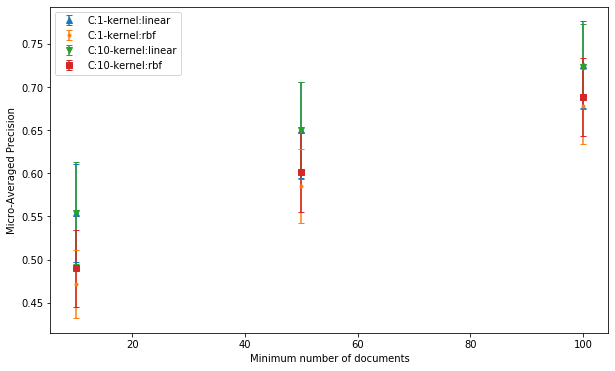

In [12]:
clf_10 = results_min_ref[10]['clf']
clf_50 = results_min_ref[50]['clf']
clf_100 = results_min_ref[100]['clf']

min_refs = [10, 50, 100]
labels = ['C:1-kernel:linear', 'C:1-kernel:rbf', 'C:10-kernel:linear', 'C:10-kernel:rbf']
markers = ['^', '.', 'v', 's']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.ylabel('Micro-Averaged Precision')
plt.xlabel('Minimum number of documents')
for i in range(4):
    x = pd.array(min_refs)
    y = clf_10.cv_results_['mean_test_precision_micro'][i], clf_50.cv_results_['mean_test_precision_micro'][i], \
        clf_100.cv_results_['mean_test_precision_micro'][i]
    e = clf_10.cv_results_['std_test_precision_micro'][i], clf_50.cv_results_['std_test_precision_micro'][i], \
        clf_100.cv_results_['std_test_precision_micro'][i]
    plt.errorbar(x, y, e, linestyle='None', marker=markers[i], label=labels[i], capsize=3)
    plt.legend(loc='upper left')

plt.savefig('data/img/precision_.png')
plt.show()
plt.close()

We repeat the process for stemmed corpus.
This results show that the best estimator is _C:1-kernel:linear_.

In [3]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from nltk.stem.porter import PorterStemmer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer

def crossval(df, min_references, stemmed=False):
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    df = df[df.cell_id.isin(pm_count[pm_count >= min_references].index)]
    df = df[df.cell_id.isin(pm_count[pm_count < 500].index)]
    print(df.shape[0], 'abstracts in corpus')
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    print('Every cell line has at least', min(pm_count), 'documents')

    if stemmed:
        stemmer = PorterStemmer()
        stemmed_corpus = list()
        for doc in df['document']:
            doc = doc.replace('.', '').replace(',', '').replace(';', '').replace(':', '')
            stemmed_corpus.append(' '.join([stemmer.stem(x) for x in doc.split()]))
        corpus = stemmed_corpus
    else:
        corpus = df['document']

    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=1.0, min_df=2, strip_accents='ascii', stop_words='english',
                                 token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
    dtm = vectorizer.fit_transform(corpus)
    print('DTM shape:', dtm.shape)
    wordfreq = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    print('Top 20 words')
    print(sorted(wordfreq.items(), key=lambda x: x[1])[:20])
    reference_vocab = vectorizer.get_feature_names()
    print(len(reference_vocab), 'words')

    X, y = dtm, df['cell_id']
    scoring = ['precision_micro', 'recall_micro']
    param_grid = {'C': [1, 10], 'kernel': ('linear', 'rbf')}
    svc = SVC(decision_function_shape='ovr')
    clf = GridSearchCV(estimator=svc, param_grid=param_grid, return_train_score=True, cv=10, n_jobs=-1,
                       scoring=scoring, refit='recall_micro', verbose=1)
    clf = clf.fit(X=X, y=y, groups=df['cell_id'])
    return {'clf': clf, 'estimator': clf.best_estimator_, 'pm_count': pm_count}


results_min_ref = dict()
for min_ref in [10, 50, 100]:
    print('_'*80)
    print(min_ref, 'minimum references')
    results_min_ref[min_ref] = crossval(df=reference_df, min_references=min_ref, stemmed=True)

clf_10 = results_min_ref[10]['clf']
clf_50 = results_min_ref[50]['clf']
clf_100 = results_min_ref[100]['clf']

min_refs = [10, 50, 100]
labels = ['C:1-kernel:linear', 'C:1-kernel:rbf', 'C:10-kernel:linear', 'C:10-kernel:rbf']
markers = ['^', '.', 'v', 's']

plt.figure(figsize=(10, 6))
plt.ylabel('Micro-Averaged Precision')
plt.xlabel('Minimum number of documents')
for i in range(4):
    x = pd.array(min_refs)
    y = clf_10.cv_results_['mean_test_precision_micro'][i], clf_50.cv_results_['mean_test_precision_micro'][i], \
        clf_100.cv_results_['mean_test_precision_micro'][i]
    e = clf_10.cv_results_['std_test_precision_micro'][i], clf_50.cv_results_['std_test_precision_micro'][i], \
        clf_100.cv_results_['std_test_precision_micro'][i]
    plt.errorbar(x, y, e, linestyle='None', marker=markers[i], label=labels[i], capsize=3)
    plt.legend(loc='upper left')

plt.savefig('data/img/precision_stemmed.png')
plt.show()
plt.close()

________________________________________________________________________________
10 minimum references
52780 abstracts in corpus
Every cell line has at least 10 documents
DTM shape: (52780, 47632)
Top 20 words
[('cell', 1.0126025252097202), ('line', 1.0241035589325231), ('wa', 1.2993129542293087), ('express', 1.6066790758515235), ('human', 1.6166683314908883), ('thi', 1.625057819873915), ('studi', 1.6319844082634294), ('use', 1.6343754305827143), ('result', 1.6465255494980209), ('activ', 1.7902664644032593), ('effect', 1.876245833895124), ('protein', 1.964884348413899), ('induc', 2.0034071797393542), ('increas', 2.079508686500078), ('cancer', 2.1033791311686043), ('suggest', 2.1156182014045783), ('gene', 2.172780016044055), ('level', 2.186152577051571), ('inhibit', 2.199832168240179), ('tumor', 2.2367963098703254)]
47632 words
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  40 | elapsed: 182.8min remaining: 379.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 226.6min finished


________________________________________________________________________________
50 minimum references
41842 abstracts in corpus
Every cell line has at least 50 documents
DTM shape: (41842, 41993)
Top 20 words
[('cell', 1.0099192628177527), ('line', 1.0185248549837316), ('wa', 1.2782389519608381), ('express', 1.5964323003152405), ('studi', 1.6148248314027882), ('thi', 1.6209426853028326), ('use', 1.6250421474204164), ('result', 1.627187687310161), ('human', 1.63189716653547), ('activ', 1.752849134696706), ('effect', 1.8325578713887933), ('protein', 1.9385352167448457), ('induc', 1.96008657726685), ('increas', 2.043698902717405), ('suggest', 2.110851401736059), ('cancer', 2.1461604836793553), ('inhibit', 2.157578808802281), ('level', 2.1594819038082083), ('gene', 2.1981663389616295), ('tumor', 2.269560770350392)]
41993 words
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  40 | elapsed: 75.9min remaining: 157.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 94.2min finished


________________________________________________________________________________
100 minimum references
33511 abstracts in corpus
Every cell line has at least 100 documents
DTM shape: (33511, 36932)
Top 20 words
[('cell', 1.0088116859679268), ('line', 1.0174891202714447), ('wa', 1.2719318504818), ('express', 1.591595532737584), ('studi', 1.6086156004820227), ('thi', 1.6160468955179994), ('result', 1.6189241176655726), ('use', 1.6269911451959866), ('human', 1.6394129669487816), ('activ', 1.7317187847833244), ('effect', 1.8178846959555006), ('induc', 1.934341790696461), ('protein', 1.9344937202014632), ('increas', 2.02225817950956), ('suggest', 2.0965256631755658), ('inhibit', 2.147095147470556), ('level', 2.1506722952179547), ('cancer', 2.1804395311003115), ('gene', 2.2089185706293613), ('tumor', 2.28825347873883)]
36932 words
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  40 | elapsed: 35.0min remaining: 72.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 46.4min finished


NameError: name 'plt' is not defined

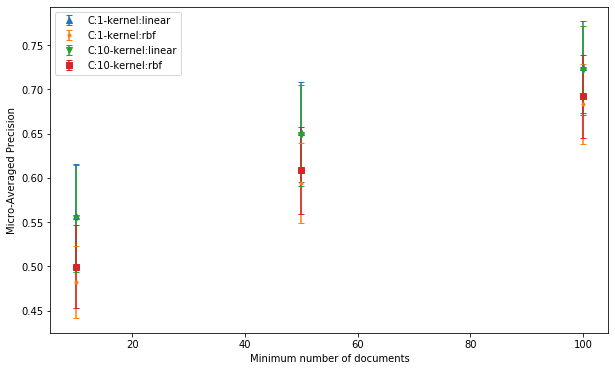

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.ylabel('Micro-Averaged Precision')
plt.xlabel('Minimum number of documents')
for i in range(4):
    x = pd.array(min_refs)
    y = clf_10.cv_results_['mean_test_precision_micro'][i], clf_50.cv_results_['mean_test_precision_micro'][i], \
        clf_100.cv_results_['mean_test_precision_micro'][i]
    e = clf_10.cv_results_['std_test_precision_micro'][i], clf_50.cv_results_['std_test_precision_micro'][i], \
        clf_100.cv_results_['std_test_precision_micro'][i]
    plt.errorbar(x, y, e, linestyle='None', marker=markers[i], label=labels[i], capsize=3)
    plt.legend(loc='upper left')

plt.savefig('data/img/precision_stemmed.png')
plt.show()
plt.close()


Now we define a pipeline for calculating Micro-Averaged precision varying the minimum number of documents per class.
We plot micro-averaged precision for Non-Stemmed corpus.

In [6]:
from sklearn.model_selection import cross_validate

def min_ref_pipeline(df, min_references, stemmed=False):
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    df = df[df.cell_id.isin(pm_count[pm_count >= min_references].index)]
    df = df[df.cell_id.isin(pm_count[pm_count < 500].index)]
    print(df.shape[0], 'abstracts in corpus')
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    print(pm_count.shape[0], 'cell lines')
    print('Every cell line has at least', min(pm_count), 'documents')

    if stemmed:
        stemmer = PorterStemmer()
        stemmed_corpus = list()
        for doc in df['document']:
            doc = doc.replace('.', '').replace(',', '').replace(';', '').replace(':', '')
            stemmed_corpus.append(' '.join([stemmer.stem(x) for x in doc.split()]))
        corpus = stemmed_corpus
    else:
        corpus = df['document']

    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=1.0, min_df=2, strip_accents='ascii', stop_words='english',
                                 token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
    dtm = vectorizer.fit_transform(corpus)
    print('DTM shape:', dtm.shape)
    wordfreq = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    print('Top 20 words')
    print(sorted(wordfreq.items(), key=lambda x: x[1])[:20])
    reference_vocab = vectorizer.get_feature_names()
    print(len(reference_vocab), 'words')

    X, y = dtm, df['cell_id']
    clf = LinearSVC(penalty='l2', multi_class='ovr', random_state=42)
    X_new = SelectFromModel(estimator=clf, threshold='median').fit_transform(X, y)
    print(X.shape, X_new.shape)

    clf = LinearSVC(penalty="l2", dual=False, tol=1e-3, multi_class='ovr', C=1)
    print('=' * 80)

    scoring = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro']
    results = cross_validate(estimator=clf, X=X_new, y=y, cv=10, n_jobs=-1, verbose=0,
                             return_estimator=True, return_train_score=True, scoring=scoring, groups=df['cell_id'])
    print(results)
    return {'clf': clf, 'results': results, 'pm_count': pm_count}


for min_ref in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    print('_'*80)
    print(min_ref, 'minimum references')
    results_min_ref[min_ref] = min_ref_pipeline(reference_df, min_references=min_ref, stemmed=False)


________________________________________________________________________________
10 minimum references
52780 abstracts in corpus
756 cell lines
Every cell line has at least 10 documents
DTM shape: (52780, 58780)
Top 20 words
[('cell', 1.0184522955857487), ('line', 1.075924084408676), ('cells', 1.2501674871604203), ('human', 1.6265811033751543), ('expression', 1.77653949828469), ('results', 1.799158394477844), ('lines', 1.9221527865028858), ('study', 2.0014453825174963), ('protein', 2.0943395858318516), ('using', 2.1268389231836755), ('cancer', 2.1414446009644768), ('induced', 2.231783768046781), ('activity', 2.310096371482535), ('showed', 2.3226751536893953), ('tumor', 2.3468594329799215), ('gene', 2.3486824545953935), ('vitro', 2.3728387538345777), ('used', 2.373063094833836), ('effect', 2.3804193808222998), ('growth', 2.3863890966656855)]
58780 words
(52780, 58780) (52780, 29390)
{'fit_time': array([335.67725158, 332.62810111, 333.09101176, 335.7927351 ,
       339.73024344, 345.9218

DTM shape: (46371, 55022)
Top 20 words
[('cell', 1.0157360343370108), ('line', 1.0575415784544364), ('cells', 1.2393013798164465), ('human', 1.6335429644051906), ('expression', 1.7678060346364375), ('results', 1.7869963389842216), ('lines', 1.9743806686945156), ('study', 1.9774134883920622), ('protein', 2.075989928480147), ('using', 2.123724423386877), ('cancer', 2.16082452607018), ('induced', 2.2014313974315973), ('activity', 2.2800888648549638), ('showed', 2.3123281101392408), ('effect', 2.3423340202493996), ('gene', 2.3620078792144863), ('tumor', 2.362176271906642), ('vitro', 2.3653811325396217), ('used', 2.368342092361223), ('growth', 2.3907899163698874)]
55022 words
(46371, 55022) (46371, 27511)
{'fit_time': array([146.02432036, 145.07971859, 143.29638362, 140.96485114,
       141.5391686 , 142.72426319, 141.15292573, 136.49932623,
       131.20345211, 110.16100264]), 'score_time': array([0.22094297, 0.21684837, 0.2277987 , 0.19954371, 0.20185137,
       0.22125888, 0.19417143, 0.

DTM shape: (41842, 52270)
Top 20 words
[('cell', 1.0143946255943683), ('line', 1.048626470376825), ('cells', 1.231947095961191), ('human', 1.6426548186440084), ('expression', 1.7666431615270874), ('results', 1.7792746904543022), ('study', 1.965720394985106), ('lines', 2.006529311541077), ('protein', 2.068642649655791), ('using', 2.1190135225484767), ('cancer', 2.1840887992555746), ('induced', 2.188863946299316), ('activity', 2.270411761806735), ('showed', 2.2989962389253042), ('effect', 2.3273398358945325), ('vitro', 2.356603079799), ('used', 2.3566958829172515), ('gene', 2.3712796694853546), ('tumor', 2.375999330879853), ('treatment', 2.395103933330922)]
52270 words
(41842, 52270) (41842, 26135)
{'fit_time': array([80.69940138, 82.52954149, 80.57159686, 79.69712973, 80.22838593,
       79.91130972, 81.73955727, 81.52156734, 80.92722368, 66.06071162]), 'score_time': array([0.17112255, 0.15520406, 0.15700006, 0.16232848, 0.15668416,
       0.15690422, 0.15780425, 0.16134548, 0.16143107,

DTM shape: (38003, 49771)
Top 20 words
[('cell', 1.0137505643894777), ('line', 1.043177589266288), ('cells', 1.2252244434241168), ('human', 1.6531717710046152), ('expression', 1.7609116129678055), ('results', 1.7776643259558873), ('study', 1.9579035259602646), ('lines', 2.0398281752770484), ('protein', 2.058308268500755), ('using', 2.116131449908467), ('induced', 2.1727324053661987), ('cancer', 2.2114737639051825), ('activity', 2.2606484134324476), ('showed', 2.3009947947216896), ('effect', 2.318150883701044), ('vitro', 2.355411077690822), ('used', 2.361142338901299), ('gene', 2.369283776152044), ('tumor', 2.3898793501977487), ('treatment', 2.394856328756231)]
49771 words
(38003, 49771) (38003, 24886)
{'fit_time': array([51.40712905, 51.01124287, 50.60030746, 50.42275858, 53.36476946,
       53.73623991, 51.70034742, 53.46222138, 51.26598072, 47.96176481]), 'score_time': array([0.13077974, 0.13205528, 0.13137984, 0.1317935 , 0.13277888,
       0.10595608, 0.12898135, 0.13428712, 0.1316

DTM shape: (34637, 47225)
Top 20 words
[('cell', 1.013281411172015), ('line', 1.0402050880161373), ('cells', 1.2228332466719438), ('human', 1.653358111494006), ('expression', 1.760928245441407), ('results', 1.771238255405361), ('study', 1.9511155549839998), ('lines', 2.0598780427395305), ('protein', 2.0617962285576574), ('using', 2.1145888823709793), ('induced', 2.1613394136704325), ('cancer', 2.2148483662760667), ('activity', 2.2526186287771575), ('showed', 2.2983018846431094), ('effect', 2.3101099043993254), ('vitro', 2.3489497377155892), ('used', 2.3606994392746703), ('gene', 2.3741848269336536), ('treatment', 2.3877389053285585), ('increased', 2.3948183755044825)]
47225 words
(34637, 47225) (34637, 23613)
{'fit_time': array([36.79046726, 35.96107841, 35.92329311, 36.35398149, 36.04188633,
       36.92418194, 36.79533863, 35.9979713 , 35.80292988, 33.74071383]), 'score_time': array([0.10660124, 0.10466623, 0.10806656, 0.10364342, 0.11029577,
       0.10978055, 0.0973084 , 0.10952401

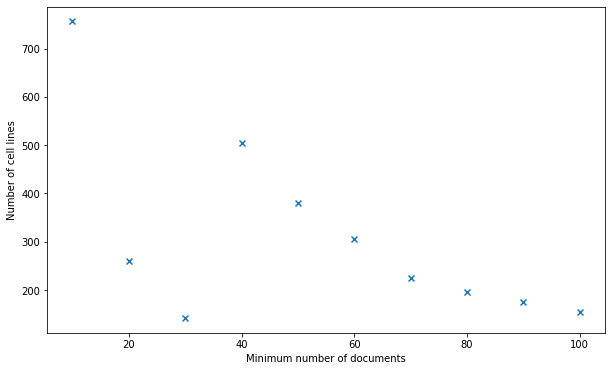

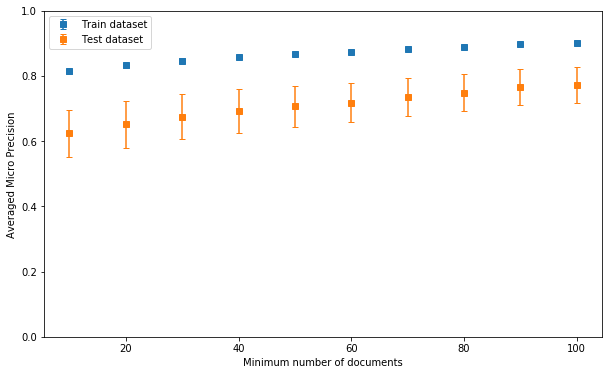

In [7]:
import matplotlib.pyplot as plt

x = sorted(list(results_min_ref.keys()))
y = [len(results_min_ref[min_ref]['pm_count']) for min_ref in results_min_ref.keys()]
min_ref_pd = pd.DataFrame(data={'Minimum number of documents': x, 'Number of cell lines': y})
plt.figure(figsize=(10, 6))
plt.ylabel('Number of cell lines')
plt.xlabel('Minimum number of documents')
plt.scatter(x, y, linestyle='None', marker='x')
plt.savefig('data/img/min_ref.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.ylabel('Averaged Micro Precision')
plt.xlabel('Minimum number of documents')

import numpy as np

x = sorted(list(results_min_ref.keys()))
y = [np.average(results_min_ref[min_ref]['results']['train_precision_micro']) for min_ref in x]
e = [np.std(results_min_ref[min_ref]['results']['train_precision_micro']) for min_ref in x]
plt.errorbar(x, y, e, linestyle='None', marker=markers[i], label='Train dataset', capsize=3)

y = [np.average(results_min_ref[min_ref]['results']['test_precision_micro']) for min_ref in x]
e = [np.std(results_min_ref[min_ref]['results']['test_precision_micro']) for min_ref in x]
plt.errorbar(x, y, e, linestyle='None', marker=markers[i], label='Test dataset', capsize=3)

plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.savefig('data/img/precision_min_ref.png')
plt.show()
plt.close()

Now we define a pipeline for calculating Micro-Averaged precision varying the variance threshold for feature selection.
We plot micro-averaged precision for Non-Stemmed corpus.


In [ ]:
from sklearn.svm import LinearSVC

def min_threshold_pipeline(df, min_references, stemmed=False):
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    df = df[df.cell_id.isin(pm_count[pm_count >= min_references].index)]
    df = df[df.cell_id.isin(pm_count[pm_count < 500].index)]
    print(df.shape[0], 'abstracts in corpus')
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    print(pm_count.shape[0], 'cell lines')
    print('Every cell line has at least', min(pm_count), 'documents')

    if stemmed:
        stemmer = PorterStemmer()
        stemmed_corpus = list()
        for doc in df['document']:
            doc = doc.replace('.', '').replace(',', '').replace(';', '').replace(':', '')
            stemmed_corpus.append(' '.join([stemmer.stem(x) for x in doc.split()]))
        corpus = stemmed_corpus
    else:
        corpus = df['document']

    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=1.0, min_df=2, strip_accents='ascii', stop_words='english',
                                 token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
    dtm = vectorizer.fit_transform(corpus)
    print('DTM shape:', dtm.shape)
    wordfreq = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    print('Top 20 words')
    print(sorted(wordfreq.items(), key=lambda x: x[1])[:20])
    reference_vocab = vectorizer.get_feature_names()
    print(len(reference_vocab), 'words')

    X, y = dtm, df['cell_id']
    clf = LinearSVC(penalty='l2', multi_class='ovr', random_state=42)
    thresholds = ['0.5*median', 'median', '1.5*median', '2*median']
    results = dict()
    for threshold in thresholds:
        print(threshold)
        X_new = SelectFromModel(estimator=clf, threshold=threshold).fit_transform(X, y)
        print(X.shape, X_new.shape)

        clf = LinearSVC(penalty="l2", dual=False, tol=1e-3, multi_class='ovr', C=1)
        print('=' * 80)

        scoring = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro']
        results[threshold] = cross_validate(estimator=clf, X=X_new, y=y, cv=10, n_jobs=-1, verbose=0,
                                 return_estimator=True, return_train_score=True, scoring=scoring, groups=df['cell_id'])
    return {'results': results}


results_min_ref_ = dict()
for min_ref in [60, 70, 80, 90, 100]:
    print('_'*80)
    print(min_ref, 'minimum references')
    results_min_ref_[min_ref] = min_threshold_pipeline(reference_df, min_references=min_ref, stemmed=False)


In [ ]:
import matplotlib.pyplot as plt
    
plt.figure(figsize=(8, 6))
plt.ylabel('Averaged Micro Precision')
plt.xlabel('Minimum number of documents')
markers = ['^', '.', 'v', 's']
thresholds = ['0.5*median', 'median', '1.5*median', '2*median']
labels = [' (threshold = 0.5*median)', ' (threshold = median)', ' (threshold = 1.5*median)', ' (threshold = 2*median)']

x = sorted(list(results_min_ref_.keys()))
for i in range(4):
    y = [np.average(results_min_ref_[min_ref]['results'][thresholds[i]]['train_precision_micro']) for min_ref in x]
    e = [np.std(results_min_ref_[min_ref]['results'][thresholds[i]]['train_precision_micro']) for min_ref in x]
    plt.errorbar(x, y, e, linestyle='None', marker='^', label='Train dataset'+labels[i], capsize=3)

    y = [np.average(results_min_ref_[min_ref]['results'][thresholds[i]]['test_precision_micro']) for min_ref in x]
    e = [np.std(results_min_ref_[min_ref]['results'][thresholds[i]]['test_precision_micro']) for min_ref in x]
    plt.errorbar(x, y, e, linestyle='None', marker='o', label='Test dataset'+labels[i], capsize=3)

plt.ylim(0.2, 1)
plt.legend(loc='lower left')

plt.savefig('data/img/precision_min_ref_threshold.png')
plt.show()
plt.close()

Now we can select the estimator for a given Minimum Reference threshold and obtain its support vector coefficients

In [ ]:
clf = results_min_ref_[60]['results']['0.5*median']['estimator'][0].densify()
coef = clf.coef_
print('Coefficient matrix of shape:',coef.shape)
print('Coefficient matrix sample:')
print(coef[:10,:10])

In [8]:
from sklearn.svm import LinearSVC

def min_threshold_pipeline(df, min_references, stemmed=False):
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    df = df[df.cell_id.isin(pm_count[pm_count >= min_references].index)]
    df = df[df.cell_id.isin(pm_count[pm_count < 500].index)]
    print(df.shape[0], 'abstracts in corpus')
    pm_count = df.groupby(by=['cell_id'])['cell_id'].count()
    print(pm_count.shape[0], 'cell lines')
    print('Every cell line has at least', min(pm_count), 'documents')

    if stemmed:
        stemmer = PorterStemmer()
        stemmed_corpus = list()
        for doc in df['document']:
            doc = doc.replace('.', '').replace(',', '').replace(';', '').replace(':', '')
            stemmed_corpus.append(' '.join([stemmer.stem(x) for x in doc.split()]))
        corpus = stemmed_corpus
    else:
        corpus = df['document']

    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=1.0, min_df=2, strip_accents='ascii', stop_words='english',
                                 token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
    dtm = vectorizer.fit_transform(corpus)
    print('DTM shape:', dtm.shape)
    wordfreq = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    print('Top 20 words')
    print(sorted(wordfreq.items(), key=lambda x: x[1])[:20])
    reference_vocab = vectorizer.get_feature_names()
    print(len(reference_vocab), 'words')

    X, y = dtm, df['cell_id']
    clf = LinearSVC(penalty='l2', multi_class='ovr', random_state=42)
    thresholds = ['0.5*median', 'median', '1.5*median', '2*median']
    results = dict()
    for threshold in thresholds:
        print(threshold)
        X_new = SelectFromModel(estimator=clf, threshold=threshold).fit_transform(X, y)
        print(X.shape, X_new.shape)

        clf = LinearSVC(penalty="l2", dual=False, tol=1e-3, multi_class='ovr', C=1)
        print('=' * 80)

        scoring = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro']
        results[threshold] = cross_validate(estimator=clf, X=X_new, y=y, cv=10, n_jobs=-1, verbose=0,
                                 return_estimator=True, return_train_score=True, scoring=scoring, groups=df['cell_id'])
    return {'results': results}


results_min_ref_ = dict()
for min_ref in [60, 70, 80, 90, 100]:
    print('_'*80)
    print(min_ref, 'minimum references')
    results_min_ref_[min_ref] = min_threshold_pipeline(reference_df, min_references=min_ref, stemmed=False)


________________________________________________________________________________
60 minimum references
39883 abstracts in corpus
225 cell lines
Every cell line has at least 60 documents
DTM shape: (39883, 51005)
Top 20 words
[('cell', 1.0141910822812474), ('line', 1.0459709546347469), ('cells', 1.2287756691891063), ('human', 1.6468482850933666), ('expression', 1.763781870747426), ('results', 1.7786917405976688), ('study', 1.962248560479329), ('lines', 2.0209717294067024), ('protein', 2.064209408461349), ('using', 2.116650852540645), ('induced', 2.1808575505624157), ('cancer', 2.1928524364072057), ('activity', 2.2655182273776115), ('showed', 2.300981011731783), ('effect', 2.3202275730148605), ('vitro', 2.354997073471283), ('used', 2.3614329806204584), ('gene', 2.370868867418829), ('tumor', 2.383990328044533), ('treatment', 2.394855626081779)]
51005 words
0.5*median
(39883, 51005) (39883, 37736)
median
(39883, 51005) (39883, 25503)
1.5*median
(39883, 51005) (39883, 19103)
2*median
(39883

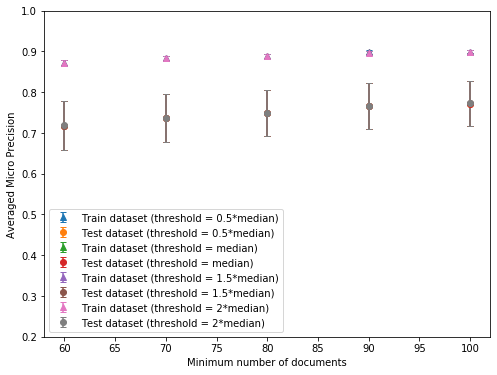

In [11]:
import matplotlib.pyplot as plt
    
plt.figure(figsize=(8, 6))
plt.ylabel('Averaged Micro Precision')
plt.xlabel('Minimum number of documents')
markers = ['^', '.', 'v', 's']
thresholds = ['0.5*median', 'median', '1.5*median', '2*median']
labels = [' (threshold = 0.5*median)', ' (threshold = median)', ' (threshold = 1.5*median)', ' (threshold = 2*median)']

x = sorted(list(results_min_ref_.keys()))
for i in range(4):
    y = [np.average(results_min_ref_[min_ref]['results'][thresholds[i]]['train_precision_micro']) for min_ref in x]
    e = [np.std(results_min_ref_[min_ref]['results'][thresholds[i]]['train_precision_micro']) for min_ref in x]
    plt.errorbar(x, y, e, linestyle='None', marker='^', label='Train dataset'+labels[i], capsize=3)

    y = [np.average(results_min_ref_[min_ref]['results'][thresholds[i]]['test_precision_micro']) for min_ref in x]
    e = [np.std(results_min_ref_[min_ref]['results'][thresholds[i]]['test_precision_micro']) for min_ref in x]
    plt.errorbar(x, y, e, linestyle='None', marker='o', label='Test dataset'+labels[i], capsize=3)

plt.ylim(0.2, 1)
plt.legend(loc='lower left')

plt.savefig('data/img/precision_min_ref_threshold.png')
plt.show()
plt.close()

Now we can select the estimator for a given Minimum Reference threshold and obtain its support vector coefficients

In [27]:
clf = results_min_ref_[60]['results']['0.5*median']['estimator'][0].densify()
coef = clf.coef_
print('Coefficient matrix of shape:',coef.shape)
print('Coefficient matrix sample:')
print(coef[:10,:10])

Coefficient matrix of shape: (225, 37736)
Coefficient matrix sample:
[[ 3.86992274e-06 -1.34404404e-06 -1.14643956e-06 -3.37848733e-07
   1.53306293e-06  4.95061511e-06 -2.83619281e-03  7.47298721e-07
  -1.40228684e-03 -2.25414802e-06]
 [ 8.23552185e-06 -1.77798879e-06  1.50249472e-06 -2.44670545e-03
   1.75971211e-05 -3.91343300e-06 -6.80927882e-06  3.73953004e-06
  -5.54817113e-07 -1.51898251e-06]
 [ 1.91871295e-06  1.74824808e-01 -3.52981251e-05  3.41311658e-06
  -8.64366832e-07 -4.14482172e-02  1.90386968e-01 -3.36898188e-06
  -6.24583636e-03  4.55941563e-07]
 [-3.74379079e-07 -1.82612763e-03 -3.23543359e-02  4.61256168e-07
   2.71723595e-07 -1.02223007e-07 -1.85970220e-07 -4.63673616e-07
   1.20553420e-07 -1.44120221e-05]
 [-2.86025648e-07 -7.82695844e-07 -4.14256818e-08  6.70667003e-08
   6.91201829e-08 -2.40642191e-08 -2.69487846e-07 -7.98861616e-08
  -1.31467911e-07 -7.48376613e-09]
 [-2.03005289e-05  2.69861659e-06 -4.66084605e-06 -4.56256059e-07
  -8.44341859e-07 -1.18585555e